# Test for getting bDSM and tDSM from LiDAR


In [2]:
import json
import pdal
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show


In [5]:
# Path to the LAS file
las_file = "../data/test/Philadelphia_100.las"

# output file
output_dsm = "data/dsm.tif"
output_dtm = "data/dtm.tif"
output_ndsm = "data/ndsm.tif"
output_bdsm = "data/bdsm.tif"
output_tdsm = "data/tdsm.tif"

In [6]:
# Create a pipeline to read the LAS file and get metadata
pipeline_json = {
    "pipeline": [
        las_file,
        {
            "type": "filters.info"
        }
    ]
}

# Run PDAL pipeline
pipeline = pdal.Pipeline(json.dumps(pipeline_json))
pipeline.execute()

# Retrieve metadata
metadata = pipeline.metadata

# Print metadata information
print(json.dumps(metadata, indent=4))


{
    "metadata": {
        "filters.info": {
            "bbox": {
                "maxx": 2648999.999,
                "maxy": 205000,
                "maxz": 259.151,
                "minx": 2647971.475,
                "miny": 202127.961,
                "minz": -177.35
            },
            "dimensions": "X, Y, Z, Intensity, ReturnNumber, NumberOfReturns, ScanDirectionFlag, EdgeOfFlightLine, Classification, Synthetic, KeyPoint, Withheld, Overlap, ScanAngleRank, UserData, PointSourceId, GpsTime, ScanChannel",
            "num_points": 5752216,
            "schema": {
                "dimensions": [
                    {
                        "name": "X",
                        "size": 8,
                        "type": "floating"
                    },
                    {
                        "name": "Y",
                        "size": 8,
                        "type": "floating"
                    },
                    {
                        "name": "Z",
      

In [5]:
nav = metadata['metadata']['filters.info']['bbox']

max_x = nav['maxx']
max_y = nav['maxy']
min_x = nav['minx']
min_y = nav['miny']

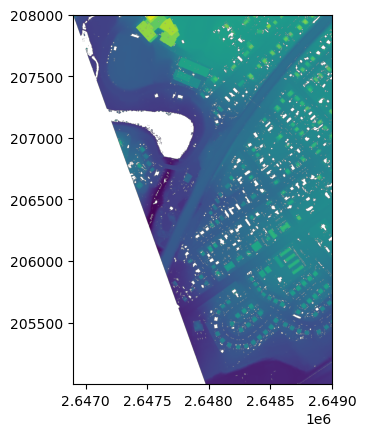

In [6]:
dtm_pipeline = {
    "pipeline": [
        las_file,
        {
            "type": "filters.smrf",  # Simple Morphological Filter to classify ground points
            "ignore": "Classification[7:7]",  # Ignore noise
            "slope": 0.2,
            "window": 16,
            "threshold": 0.5,
            "cell": 1.0
        },
        {
            "type": "filters.range",
            "limits": "Classification[2:2]"  # Select only ground points
        },
        {
            "type": "writers.gdal",
            "filename": output_dtm,
            "output_type": "idw",  # Inverse Distance Weighting interpolation
            "resolution": 1.0,
            "bounds": f"([{min_x}, {max_x}], [{min_y}, {max_y}])"
        }
    ]
}

# Initialize the PDAL pipeline with the JSON string.
p_dtm = pdal.Pipeline(json.dumps(dtm_pipeline))

# Execute the pipeline.
p_dtm.execute()

# Load the DTM raster and display it
with rasterio.open(output_dtm) as src:
    dtm_data = src.read(1)
    show(src)


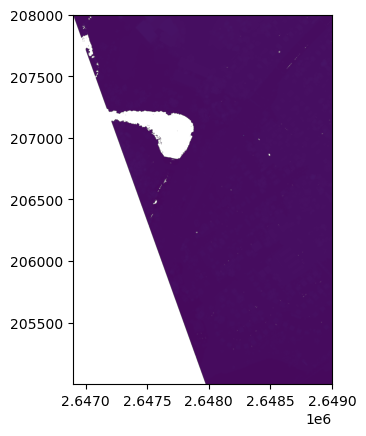

In [7]:
dsm_pipeline = {
    "pipeline": [
        las_file,
        {
            "type": "writers.gdal",
            "filename": output_dsm,
            "output_type": "idw",
            "resolution": 1.0,
            "bounds": f"([{min_x}, {max_x}], [{min_y}, {max_y}])"
        }
    ]
}

# Execute the pipeline
p_dsm = pdal.Pipeline(json.dumps(dsm_pipeline))
p_dsm.execute()

# Load the DSM raster and display it
with rasterio.open(output_dsm) as src:
    dsm_data = src.read(1)
    show(src)


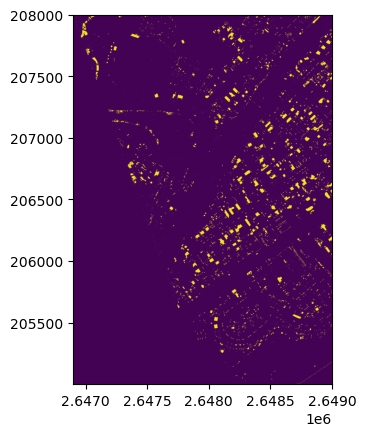

In [8]:
# Load the DSM and DTM data
with rasterio.open(output_dsm) as dsm_src, rasterio.open(output_dtm) as dtm_src:
    dsm_data = dsm_src.read(1)
    dtm_data = dtm_src.read(1)

    # Compute nDSM
    ndsm_data = dsm_data - dtm_data

    # Save the result as a new raster
    ndsm_meta = dsm_src.meta.copy()
    ndsm_meta.update({"dtype": "float32"})

    with rasterio.open(output_ndsm, "w", **ndsm_meta) as dst:
        dst.write(ndsm_data.astype(np.float32), 1)

# Display nDSM
with rasterio.open(output_ndsm) as src:
    show(src)
